### 一.简介
xgboost分类分两种情况，二分类和多分类：  

（1） 二分类的思路与[logistic回归](https://nbviewer.jupyter.org/github/zhulei227/ML_Notes/blob/master/notebooks/02_%E7%BA%BF%E6%80%A7%E6%A8%A1%E5%9E%8B_%E9%80%BB%E8%BE%91%E5%9B%9E%E5%BD%92.ipynb)一样，先对线性函数套一个`sigmoid`函数，然后再求交叉熵作为损失函数，所以只需要一组回归树并可实现；   

（2）而多分类的实现，思路同[gbm_classifier](https://nbviewer.jupyter.org/github/zhulei227/ML_Notes/blob/master/notebooks/10_06_%E9%9B%86%E6%88%90%E5%AD%A6%E4%B9%A0_boosting_gbm_classifier.ipynb)一样，即同时训练多组回归树，每一组代表一个class，然后对其进行`softmax`操作，然后再求交叉熵做为损失函数  

下面对多分类的情况再推一次损失函数、一阶导、二阶导：   

softmax转换：  


$$
softmax(\hat{y})=softmax([\hat{y_1},\hat{y_2},...,\hat{y_n}])=\frac{1}{\sum_{i=1}^n e^{\hat{y_i}}}[e^{\hat{y_1}},e^{\hat{y_2}},...,e^{\hat{y_n}}]
$$   

交叉熵：   

$$
cross\_entropy(y,p)=-\sum_{i=1}^n y_ilog p_i
$$  

将$p_i$替换为$\frac{e^{y_i^{hat}}}{\sum_{i=1}^n e^{y_i^{hat}}}$，得到损失函数如下：   

$$
L(y^{hat},y)=-\sum_{i=1}^n y_ilog \frac{e^{y_i^{hat}}}{\sum_{j=1}^n e^{x_j^{hat}}}\\
=-\sum_{i=1}^n y_i(y_i^{hat}-log\sum_{j=1}^n e^{y_j^{hat}})\\
    =log\sum_{i=1}^n e^{y_i^{hat}}-\sum_{i=1}^ny_iy_i^{hat}（由于是onehot展开，所以\sum_{i=1}^n y_i=1）
$$  

所以一阶导：  

$$
\frac{\partial L(y^{hat},y)}{\partial y^{hat}}=softmax([y_1^{hat},y_2^{hat},...,y_n^{hat}])-[y_1,y_2,...,y_n]\\
=softmax(y^{hat})-y
$$    

二阶导：  

$$
\frac{\partial^2 L(y^{hat},y)}{\partial {y^{hat}}^2}=softmax(y^{hat})(1-softmax(y^{hat}))
$$


### 二.代码实现

In [95]:
import os
os.chdir('../')
from ml_models.ensemble import XGBoostBaseTree
from ml_models import utils
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

"""
xgboost分类树的实现，封装到ml_models.ensemble
"""


class XGBoostClassifier(object):
    def __init__(self, base_estimator=None, n_estimators=50, learning_rate=1.0):
        """
        :param base_estimator: 基学习器
        :param n_estimators: 基学习器迭代数量
        :param learning_rate: 学习率，降低后续基学习器的权重，避免过拟合
        """
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        if self.base_estimator is None:
            self.base_estimator = XGBoostBaseTree()
        # 同质分类器
        if type(base_estimator) != list:
            estimator = self.base_estimator
            self.base_estimator = [copy.deepcopy(estimator) for _ in range(0, self.n_estimators)]
        # 异质分类器
        else:
            self.n_estimators = len(self.base_estimator)

        # 扩展class_num组分类器
        self.expand_base_estimators = []

    def fit(self, x, y):
        # 将y转one-hot编码
        class_num = np.amax(y) + 1
        y_cate = np.zeros(shape=(len(y), class_num))
        y_cate[np.arange(len(y)), y] = 1

        # 扩展分类器
        self.expand_base_estimators = [copy.deepcopy(self.base_estimator) for _ in range(class_num)]

        # 第一个模型假设预测为0
        y_pred_score_ = np.zeros(shape=(x.shape[0], class_num))
        # 计算一阶、二阶导数
        g = utils.softmax(y_pred_score_) - y_cate
        h = utils.softmax(y_pred_score_) * (1 - utils.softmax(y_pred_score_))
        # 训练后续模型
        for index in range(0, self.n_estimators):
            y_pred_score = []
            for class_index in range(0, class_num):
                self.expand_base_estimators[class_index][index].fit(x, g[:, class_index], h[:, class_index])
                y_pred_score.append(self.expand_base_estimators[class_index][index].predict(x))
            y_pred_score_ += np.c_[y_pred_score].T * self.learning_rate
            g = utils.softmax(y_pred_score_) - y_cate
            h = utils.softmax(y_pred_score_) * (1 - utils.softmax(y_pred_score_))

    def predict_proba(self, x):
        # TODO:并行优化
        y_pred_score = []
        for class_index in range(0, len(self.expand_base_estimators)):
            estimator_of_index = self.expand_base_estimators[class_index]
            y_pred_score.append(
                np.sum(
                    [estimator_of_index[0].predict(x)] +
                    [self.learning_rate * estimator_of_index[i].predict(x) for i in
                     range(1, self.n_estimators - 1)] +
                    [estimator_of_index[self.n_estimators - 1].predict(x)]
                    , axis=0)
            )
        return utils.softmax(np.c_[y_pred_score].T)

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

In [100]:
#造伪数据
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
data, target = make_classification(n_samples=150, n_features=2, n_classes=2, n_informative=1, n_redundant=0,
                                   n_repeated=0, n_clusters_per_class=1, class_sep=.5,random_state=21)
X_train,X_test,y_train, y_test = train_test_split(data, target,random_state = 21)
classifier = XGBoostClassifier(n_estimators = 50)

In [101]:
classifier.fit(X_train,y_train)

In [102]:
def plot_descision_boundary(X,target,title_ = 'Decision Boundary of XGBoost Classifier'):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.figure(figsize = (12,7))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], alpha=0.8, c=target, edgecolor='k')
    plt.title(title_)

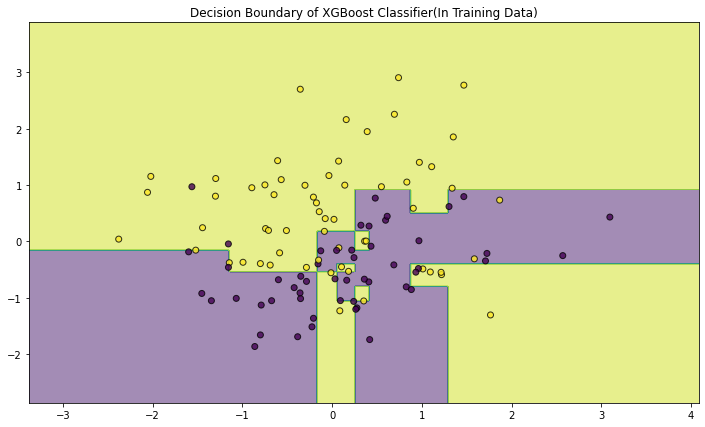

In [103]:
plot_descision_boundary(X_train, y_train,'Decision Boundary of XGBoost Classifier(In Training Data)')

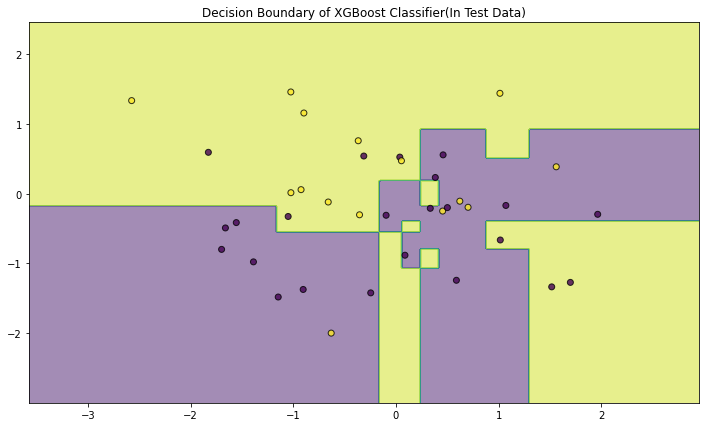

In [104]:
plot_descision_boundary(X_test, y_test,'Decision Boundary of XGBoost Classifier(In Test Data)')

In [111]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp
y_pred = classifier.predict_proba(data).max(axis=1)

C:\Users\QR_Zh\AppData\Local\Temp\ipykernel_22772\503896222.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\QR_Zh\AppData\Local\Temp\ipykernel_22772\503896222.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\QR_Zh\AppData\Local\Temp\ipykernel_22772\503896222.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\QR_Zh\AppData\Local\Temp\ipykernel_22772\503896222.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\QR_Zh\AppData\Local\Temp\ipykernel_22772\503896222.py:13: DeprecationWarning: scipy.interp is deprecated and will be remove

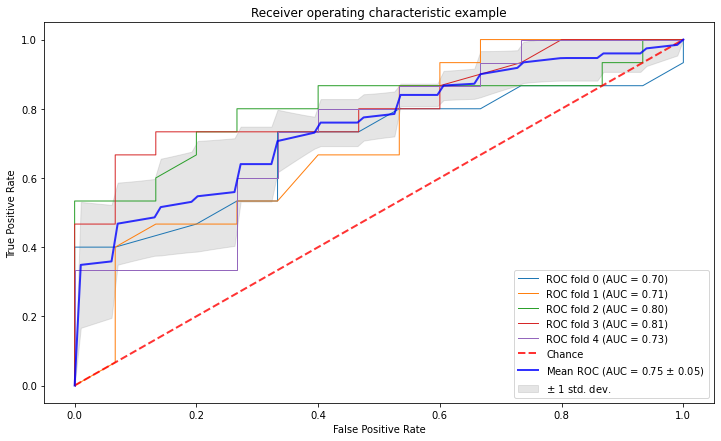

In [118]:
# plot ROC curve and area the curve
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
cv = StratifiedKFold(5)
plt.figure(figsize = (12,7))
for train, test in cv.split(data, target):
    probas_ = classifier.fit(data[train], target[train])
    probas_ = classifier.predict_proba(data[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(target[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=1.0,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
# 画图
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()



In [108]:
classifier.fit(data[train], target[train])